In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 
from sklearn.preprocessing import StandardScaler

### Load Dataset

Make sure that training and validation set end at episode.

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul

In [7]:
#drop na columns 
all_df = all_df.dropna()

In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
def getSensorReadingsOnlyNoEpisode(lst):
    result = []
    time = []
    for episode in lst:
        for row in episode:
            row_formatted = row[1:5]
            result.append(row_formatted)
            time.append(row[0])
    return (result, time)

In [11]:
#set random seed 
import tensorflow as tf
tf.random.set_seed(42)

In [12]:
train_arr, trainTime = getSensorReadingsOnlyNoEpisode(train_data)
val_arr, valTime = getSensorReadingsOnlyNoEpisode(val_data)
test_arr, testTime = getSensorReadingsOnlyNoEpisode(test_data)

In [13]:
train_arr

[[0.379151092, 0.5563851870000001, 0.24307950600000003, 0.229504293],
 [0.415506993, 0.698561103, 0.242410288, 0.273824561],
 [0.33934205, 0.637644818, 0.230266358, 0.191588098],
 [0.343817356, 0.627731997, 0.233904513, 0.264566349],
 [0.310361557, 0.6073681129999999, 0.19429564300000002, 0.240200195],
 [0.33632763600000004, 0.531479142, 0.215693485, 0.215780325],
 [0.397831149, 0.57521239, 0.19058554600000002, 0.230599092],
 [0.385974096, 0.630933953, 0.208516333, 0.24769339699999998],
 [0.376943194, 0.39604728299999997, 0.215659658, 0.256992779],
 [0.56498231, 0.648197926, 0.516587151, 0.256162471],
 [0.35186714700000005, 0.647795783, 0.257161825, 0.276671218],
 [0.353867353, 0.615858294, 0.19700913399999997, 0.26938823100000003],
 [0.38416982299999997, 0.622861995, 0.199791766, 0.305659257],
 [0.35315408200000004, 0.5978954089999999, 0.2172971, 0.265631153],
 [0.382126061, 0.655505276, 0.231748822, 0.258702261],
 [0.374770865, 0.6761454509999999, 0.243662648, 0.259956326],
 [0.40600

In [14]:
def getStateValues(lst):
    stateList = []
    for episode in lst:
        for row in episode:
            stateValue = int(row[6])
            stateList.append(stateValue)
    return stateList

In [15]:
train_state = getStateValues(train_data)
val_state = getStateValues(val_data)
test_state = getStateValues(test_data)

In [16]:
total_num = len(train_state)
failure_states = [i for i in train_state if i > 3]
failure_num = len(failure_states)
outlier_ratio = failure_num/total_num
print("Estimated percentage of outliers %f" % outlier_ratio)

Estimated percentage of outliers 0.083361


In [17]:
def viewOutliers(clf):
    #training set
    y_train_scores = clf.decision_scores_
    plt.hist(y_train_scores, bins='auto') 
    plt.title("Histogram for training set anomaly scores")
    plt.show()
    
    #validation set
    y_val_scores = clf.decision_function(val_arr)  # outlier scores
    y_val_scores = pd.Series(y_val_scores)
    plt.hist(y_val_scores, bins='auto') 
    plt.title("Histogram for validation set anomaly scores")
    plt.show()

In [18]:
def countForStates(data):
    state0_count = 0
    state1_count = 0
    state2_count = 0
    state3_count = 0
    state8_count = 0
    state9_count = 0
    
    for item in data:
        if item == 0:
            state0_count += 1
        elif item == 1:
            state1_count += 1
        elif item == 2:
            state2_count += 1
        elif item == 3:
            state3_count += 1
        elif item == 4:
            state8_count += 1
        elif item == 5: 
            state9_count += 1
            
    return [state0_count, state1_count, state2_count, state3_count, state8_count, state9_count]

In [19]:
def processAnomalyWithoutState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order]
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.bar(x=[0,1,2,3,8,9], height = countForStates(graphData))
    fullDataType = 'Validation' if dataType == 'Val' else dataType
    plt.title(f'Current machine state - {fullDataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train45count = train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train4percent = train4count/traintotalcount
        train5percent = train5count/traintotalcount
        train45percent = train45count/traintotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in training set: %f" % train45percent)
        
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain45Count = orgTrain4Count + orgTrain5Count
        orgtrain4percent = train4count/orgTrain4Count
        orgtrain5percent = train5count/orgTrain5Count
        orgtrain45percent = train45count/orgTrain45Count
        print("Percentage of points in state 4 and 5 in training set identified as anomalies: %f" % orgtrain45percent)
    elif (dataType == 'Val'): #validation set
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val45count = val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val4percent = val4count/valtotalcount
        val5percent = val5count/valtotalcount
        val45percent = val45count/valtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in validation set: %f" % val45percent)
        
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal45Count = orgVal4Count + orgVal5Count
        orgVal4percent = val4count/orgVal4Count
        orgVal5percent = val5count/orgVal5Count
        orgVal45percent = val45count/orgVal45Count
        print("Percentage of points in state 4 and 5 in validation set identified as anomalies: %f" % orgVal45percent)
    elif (dataType == 'Test'): #test set
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test45count = test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test4percent = test4count/testtotalcount
        test5percent = test5count/testtotalcount
        test45percent = test45count/testtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in test set: %f" % test45percent)
        
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest45Count = orgTest4Count + orgTest5Count
        orgTest4percent = test4count/orgTest4Count
        orgTest5percent = test5count/orgTest5Count
        orgTest45percent = test45count/orgTest45Count
        print("Percentage of points in state 4 and 5 in test set identified as anomalies: %f" % orgTest45percent)

In [20]:
def processAnomalyWithState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order]
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.hist(graphData, bins=[0,1,2,3,4,5,6])
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train3count = anomalousStateListTrain.count(3.0)
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train345count = train3count + train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train345percent = train345count/traintotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in training set: %f" % train345percent)
        
        orgTrain3Count = train_state.count(3)
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain345Count = orgTrain3Count + orgTrain4Count + orgTrain5Count
        orgtrain345percent = train345count/orgTrain345Count
        print("Percentage of points in state 3, 4 and 5 in training set identified as anomalies: %f" % orgtrain345percent)
    elif (dataType == 'Val'): #validation set
        val3count = anomalousStateListVal.count(3.0)
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val345count = val3count + val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val345percent = val345count/valtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: %f" % val345percent)
        
        orgVal3Count = val_state.count(3)
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal345Count = orgVal3Count + orgVal4Count + orgVal5Count
        orgVal345percent = val345count/orgVal345Count
        print("Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: %f" % orgVal345percent)
    elif (dataType == 'Test'): #test set
        test3count = anomalousStateListTest.count(3.0)
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test345count = test3count + test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test345percent = test345count/testtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in test set: %f" % test345percent)
        
        orgTest3Count = test_state.count(3)
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest345Count = orgTest3Count + orgTest4Count + orgTest5Count
        orgTest345percent = test345count/orgTest345Count
        print("Percentage of points in state 3, 4 and 5 in test set identified as anomalies: %f \n" % orgTest345percent)

### Isolation Forest

In [21]:
allValuesList = dataset.values.tolist()
allValuesList

[[0.0, 0.379151092, 0.5563851870000001, 0.24307950600000003, 0.229504293, 0.0],
 [1.0, 0.415506993, 0.698561103, 0.242410288, 0.273824561, 1.0],
 [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 2.0],
 [3.0, 0.343817356, 0.627731997, 0.233904513, 0.264566349, 2.0],
 [4.0, 0.310361557, 0.6073681129999999, 0.19429564300000002, 0.240200195, 2.0],
 [5.0, 0.33632763600000004, 0.531479142, 0.215693485, 0.215780325, 2.0],
 [6.0, 0.397831149, 0.57521239, 0.19058554600000002, 0.230599092, 2.0],
 [7.0, 0.385974096, 0.630933953, 0.208516333, 0.24769339699999998, 2.0],
 [8.0, 0.376943194, 0.39604728299999997, 0.215659658, 0.256992779, 3.0],
 [9.0, 0.56498231, 0.648197926, 0.516587151, 0.256162471, 4.0],
 [10.0, 0.35186714700000005, 0.647795783, 0.257161825, 0.276671218, 0.0],
 [11.0,
  0.353867353,
  0.615858294,
  0.19700913399999997,
  0.26938823100000003,
  0.0],
 [12.0, 0.38416982299999997, 0.622861995, 0.199791766, 0.305659257, 0.0],
 [13.0, 0.35315408200000004, 0.5978954089999999, 0.

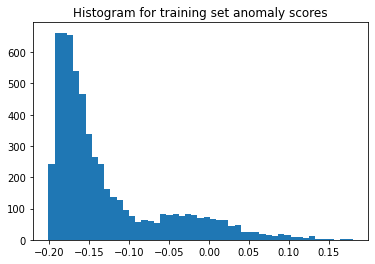

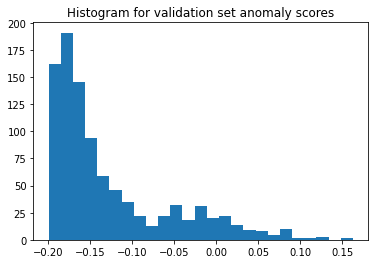

In [22]:
from pyod.models.iforest import IForest
clf1 = IForest(bootstrap=True, n_estimators=600, random_state=42, contamination=outlier_ratio)
clf1.fit(train_arr)
viewOutliers(clf1)

In [23]:
clf1.get_params()

{'behaviour': 'old',
 'bootstrap': True,
 'contamination': 0.08336106489184693,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 600,
 'n_jobs': 1,
 'random_state': 42,
 'verbose': 0}

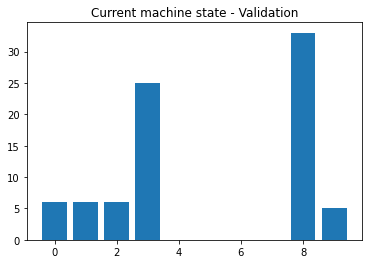

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.469136
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.457831


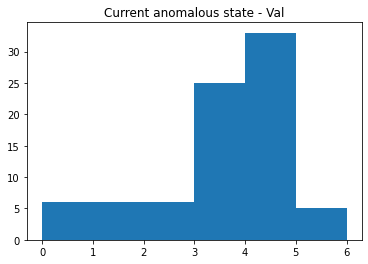

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.777778
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.228261


In [24]:
threshold = 0
val_score1 = clf1.decision_function(val_arr)
processAnomalyWithoutState3(val_score1, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score1, val_arr, threshold, 'Val')

In [25]:
from joblib import dump
dump(clf1, 'IForest.joblib')

['IForest.joblib']

### Clustering Based Local Outlier Factor

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


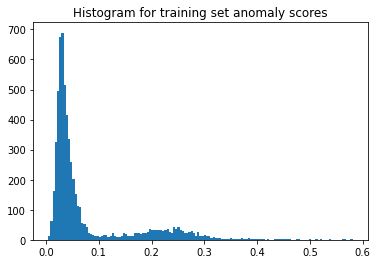

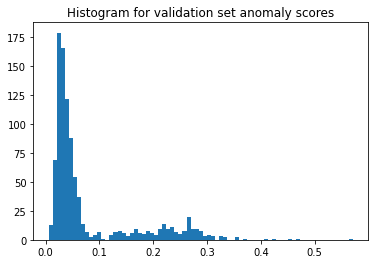

In [26]:
from pyod.models.cblof import CBLOF
clf2 = CBLOF(n_clusters=40, alpha=0.5, beta=8, use_weights=False, random_state=42, contamination=outlier_ratio)
clf2.fit(train_arr)
viewOutliers(clf2)

In [27]:
train_arr

[[0.379151092, 0.5563851870000001, 0.24307950600000003, 0.229504293],
 [0.415506993, 0.698561103, 0.242410288, 0.273824561],
 [0.33934205, 0.637644818, 0.230266358, 0.191588098],
 [0.343817356, 0.627731997, 0.233904513, 0.264566349],
 [0.310361557, 0.6073681129999999, 0.19429564300000002, 0.240200195],
 [0.33632763600000004, 0.531479142, 0.215693485, 0.215780325],
 [0.397831149, 0.57521239, 0.19058554600000002, 0.230599092],
 [0.385974096, 0.630933953, 0.208516333, 0.24769339699999998],
 [0.376943194, 0.39604728299999997, 0.215659658, 0.256992779],
 [0.56498231, 0.648197926, 0.516587151, 0.256162471],
 [0.35186714700000005, 0.647795783, 0.257161825, 0.276671218],
 [0.353867353, 0.615858294, 0.19700913399999997, 0.26938823100000003],
 [0.38416982299999997, 0.622861995, 0.199791766, 0.305659257],
 [0.35315408200000004, 0.5978954089999999, 0.2172971, 0.265631153],
 [0.382126061, 0.655505276, 0.231748822, 0.258702261],
 [0.374770865, 0.6761454509999999, 0.243662648, 0.259956326],
 [0.40600

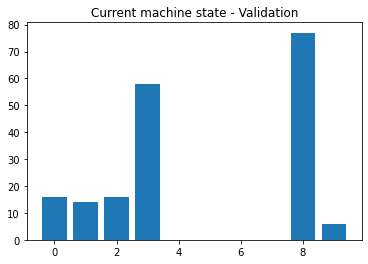

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.443850
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


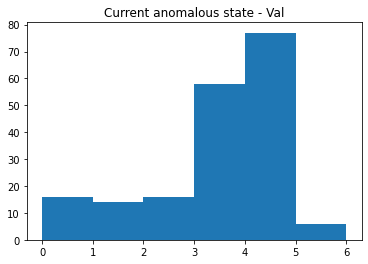

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.754011
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.510870


In [28]:
threshold = 0.1387
val_score2 = clf2.decision_function(val_arr)
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

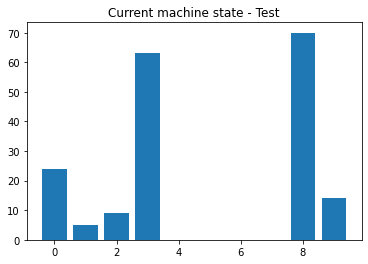

Percentage of anomalies identified belonging to state 4 and state 5 in test set: 0.454054
Percentage of points in state 4 and 5 in test set identified as anomalies: 1.000000


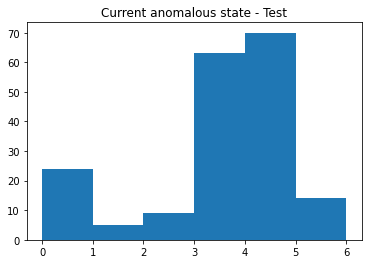

Percentage of anomalies identified belonging to state 3, 4 and 5 in test set: 0.794595
Percentage of points in state 3, 4 and 5 in test set identified as anomalies: 0.526882 



In [29]:
threshold = 0.1387
test_score2 = clf2.decision_function(test_arr)
processAnomalyWithoutState3(test_score2, test_arr, threshold, 'Test')
processAnomalyWithState3(test_score2, test_arr, threshold, 'Test')

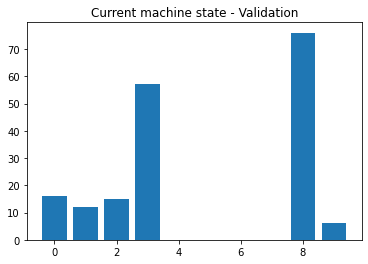

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.450549
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


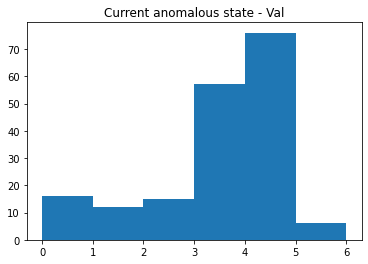

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.763736
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.503623


In [30]:
threshold = 0.1437
val_score2 = clf2.decision_function(val_arr)
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

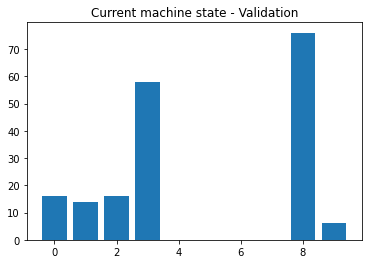

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.440860
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


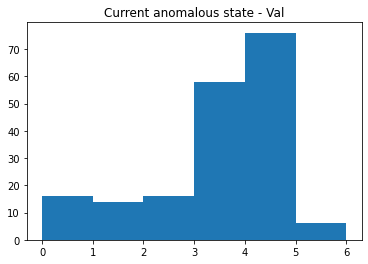

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.752688
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.507246


In [31]:
threshold = 0.1407
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

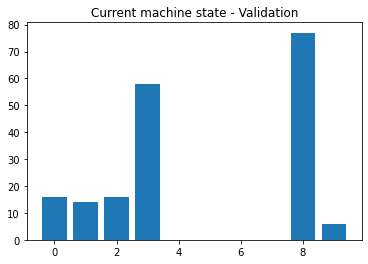

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.443850
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


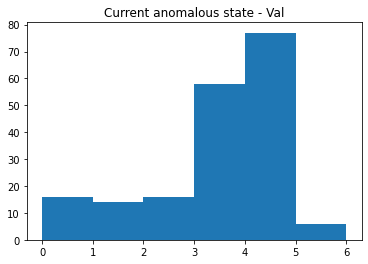

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.754011
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.510870


In [32]:
threshold = 0.1397
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

In [33]:
from joblib import dump
dump(clf2, 'CBLOF.joblib')

['CBLOF.joblib']

### Autoencoders

Current best tuned model

In [56]:
autoencoder2 = tf.keras.models.load_model("AE_tuneActivation_code_relu.h5")
val_predictions2 = autoencoder2.predict(val_arr)
val_score2 = (np.mean(np.power(val_arr - val_predictions2, 2), axis=1))**0.5

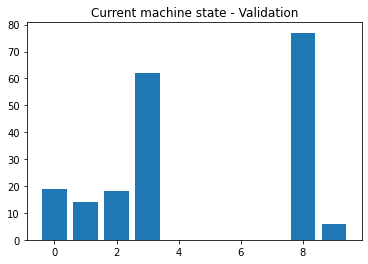

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.423469
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


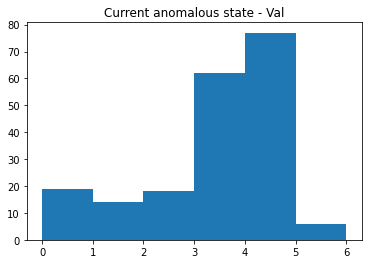

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.739796
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.525362


In [57]:
threshold=0.0783
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

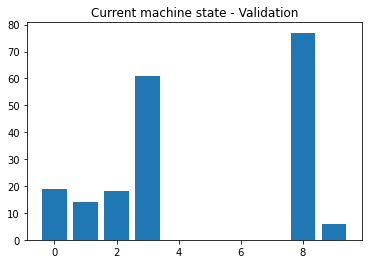

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.425641
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


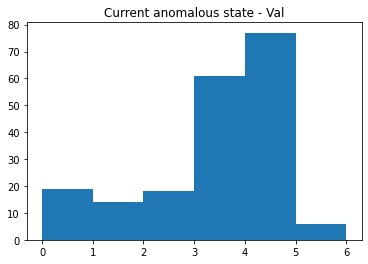

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.738462
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.521739


In [58]:
threshold=0.0789
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

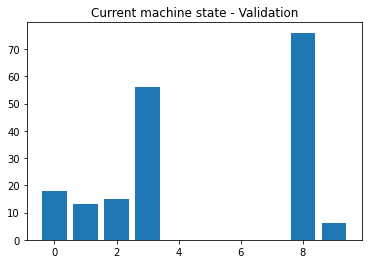

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.445652
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


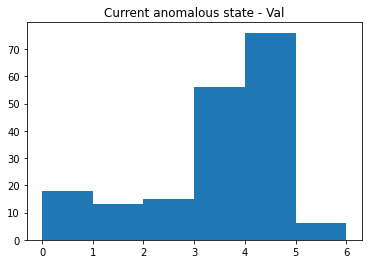

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.750000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000


In [59]:
threshold=0.0882
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

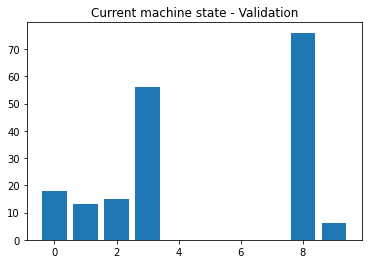

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.445652
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


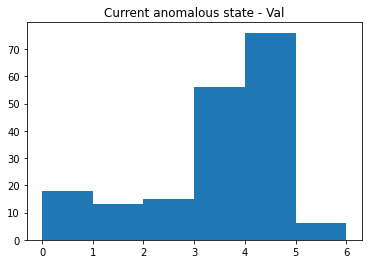

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.750000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000


In [60]:
threshold=0.0880
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

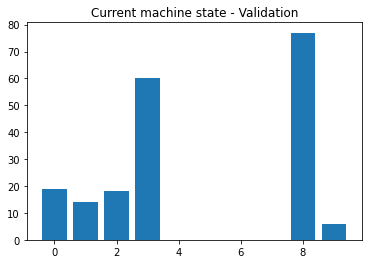

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.427835
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


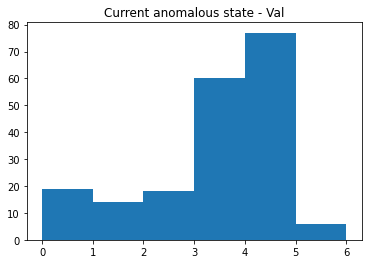

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.737113
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.518116


In [61]:
threshold=0.0795
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

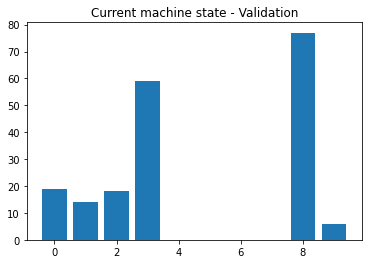

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.430052
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


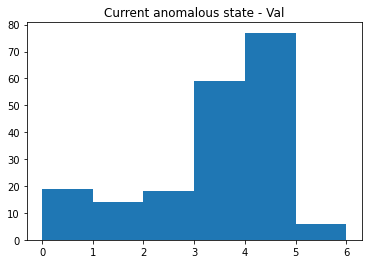

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.735751
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.514493


In [62]:
threshold=0.0798
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

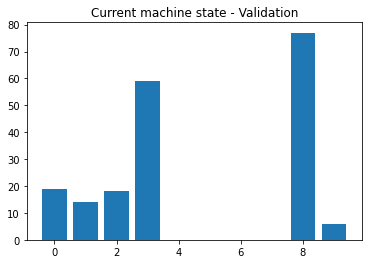

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.430052
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


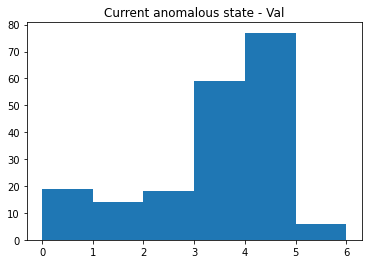

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.735751
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.514493


In [63]:
threshold=0.0799
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

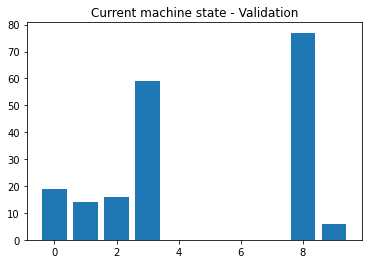

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.434555
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


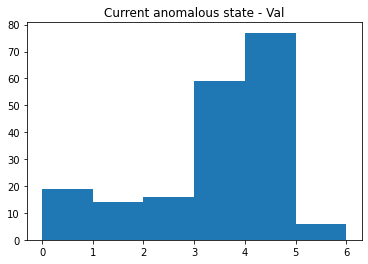

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743455
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.514493


In [65]:
threshold=0.0830
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

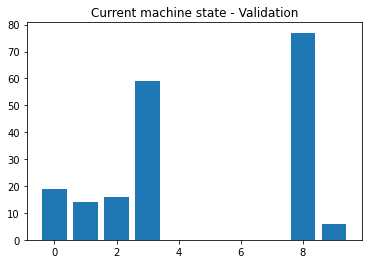

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.434555
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


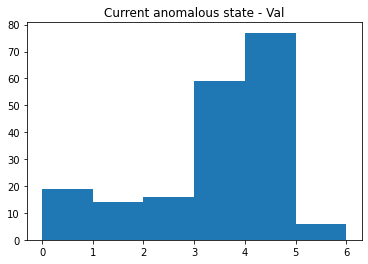

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743455
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.514493


In [66]:
threshold=0.0840
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

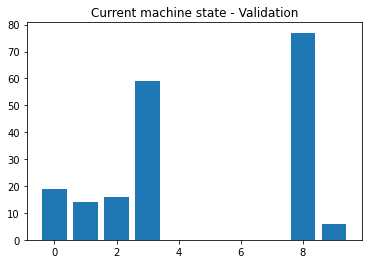

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.434555
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


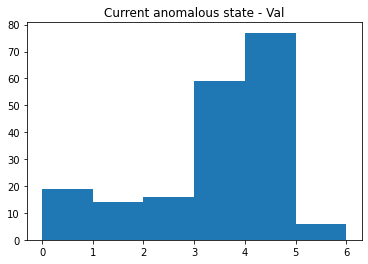

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743455
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.514493


In [67]:
threshold=0.0835
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

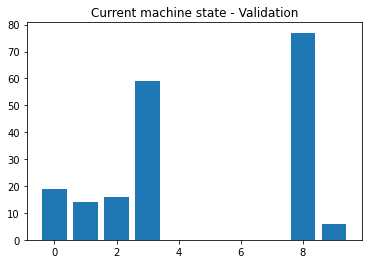

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.434555
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


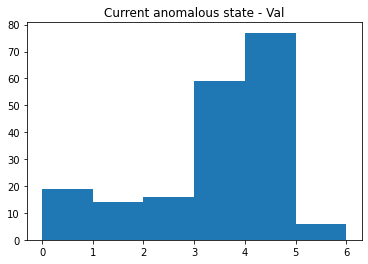

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743455
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.514493


In [68]:
threshold=0.0838
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')

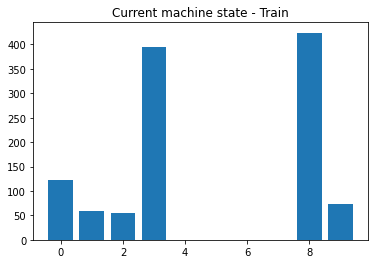

Percentage of anomalies identified belonging to state 4 and state 5 in training set: 0.440994
Percentage of points in state 4 and 5 in training set identified as anomalies: 0.992016


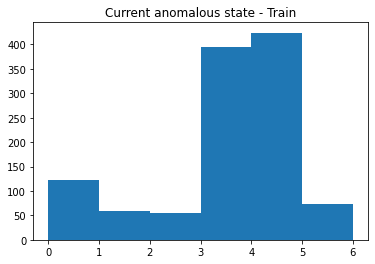

Percentage of anomalies identified belonging to state 3, 4 and 5 in training set: 0.791482
Percentage of points in state 3, 4 and 5 in training set identified as anomalies: 0.494183


In [69]:
threshold=0.0838
train_predictions2 = autoencoder2.predict(train_arr)
train_score2 = (np.mean(np.power(train_arr - train_predictions2, 2), axis=1))**0.5
processAnomalyWithoutState3(train_score2, train_arr, threshold, 'Train')
processAnomalyWithState3(train_score2, train_arr, threshold, 'Train')

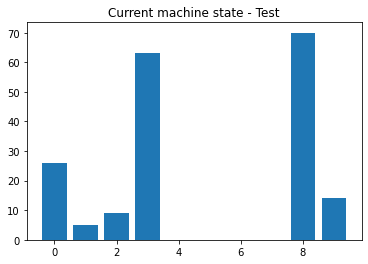

Percentage of anomalies identified belonging to state 4 and state 5 in test set: 0.449198
Percentage of points in state 4 and 5 in test set identified as anomalies: 1.000000


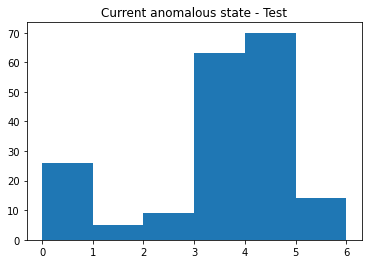

Percentage of anomalies identified belonging to state 3, 4 and 5 in test set: 0.786096
Percentage of points in state 3, 4 and 5 in test set identified as anomalies: 0.526882 



In [70]:
threshold=0.0838
test_predictions2 = autoencoder2.predict(test_arr)
test_score2 = (np.mean(np.power(test_arr - test_predictions2, 2), axis=1))**0.5
processAnomalyWithoutState3(test_score2, test_arr, threshold, 'Test')
processAnomalyWithState3(test_score2, test_arr, threshold, 'Test')

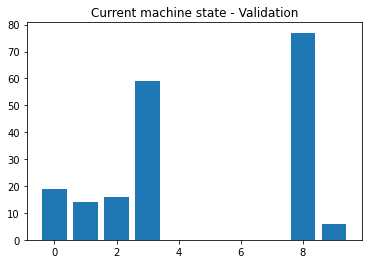

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.434555
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


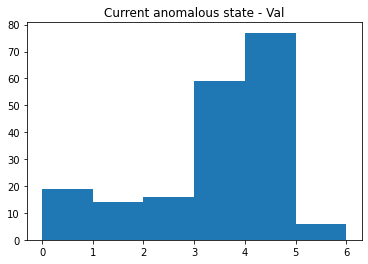

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743455
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.514493


In [71]:
threshold=0.0839
processAnomalyWithoutState3(val_score2, val_arr, threshold, 'Val')
processAnomalyWithState3(val_score2, val_arr, threshold, 'Val')